In [1]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])

In [2]:
class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

In [3]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [4]:
import numpy as np
import torch
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 200
l3 = 120
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [5]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000 #A
batch_size = 200 #B
replay = deque(maxlen=mem_size) #C
max_moves = 50 #D

h = 0
w, h = 18, 300000
matrix = [[0 for x in range(w)] for y in range(h)] 

e = 0
e,r= 10, 3000000 
experience = [[0 for x in range(e)] for y in range(r)] 

y = 0
u,y= 7, 3000000 
q_table = [[0 for x in range(u)] for y in range(y)] 
q_counter = 0 

counter = 0
num = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        
        matrix[counter][9] = qval_[0][np.argmax(qval_)]
        matrix[counter][10] = qval_[0][0]
        matrix[counter][11] = qval_[0][1]
        matrix[counter][12] = qval_[0][2]
        matrix[counter][13] = qval_[0][3]
        
        for k in range(0,4):
            q_table[q_counter][0] = i
            q_table[q_counter][1] = (str(game.board.components['Player'].pos))
            q_table[q_counter][2] = (str(game.board.components['Pit'].pos))
            q_table[q_counter][3] = (str(game.board.components['Goal'].pos))
            q_table[q_counter][4] = (str(game.board.components['Wall'].pos))
            q_table[q_counter][5] = k
            q_table[q_counter][6] = qval_[0][k]
            q_counter+=1
            
        if (random.random() < epsilon): #F
            matrix[counter][8] = 1 
            action_ = np.random.randint(0,4)
        else:
            matrix[counter][8] = 0 
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        
        matrix[counter][0] = i
        matrix[counter][1] = (str(game.board.components['Player'].pos))
        matrix[counter][2] = (str(game.board.components['Pit'].pos))
        matrix[counter][3] = (str(game.board.components['Goal'].pos))
        matrix[counter][4] = (str(game.board.components['Wall'].pos))
        matrix[counter][5] = action_
        
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        next_state = model(state2)
        next_state_ = next_state.data.numpy()
        matrix[counter][14] = next_state_[0][0]
        matrix[counter][15] = next_state_[0][1]
        matrix[counter][16] = next_state_[0][2]
        matrix[counter][17] = next_state_[0][3]
        reward = game.reward()
        matrix[counter][6] = reward
        done = True if reward > 0 else False
        matrix[counter][7] = (str(game.board.components['Player'].pos))
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i)
            if (i >= 4500):
                for j in range (0, batch_size):
                    experience[num][0] = i
                    experience[num][1] = state1_batch[j].numpy()
                    experience[num][2] = action_batch[j].item()
                    experience[num][3] = reward_batch[j].item()
                    experience[num][4] = state2_batch[j].numpy()
                    experience[num][5] = done_batch[j].item()
                    experience[num][6] = Q1[j].detach().numpy()
                    experience[num][7] = Q2[j].detach().numpy()
                    experience[num][8] = Y[j].item()
                    experience[num][9] = X[j].item()
                    num += 1
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
        counter += 1
        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

4999


In [68]:
q_table

[[0, '(1, 2)', '(2, 2)', '(0, 0)', '(3, 0)', 0, -3.2709532],
 [0, '(1, 2)', '(2, 2)', '(0, 0)', '(3, 0)', 1, -0.47969717],
 [0, '(1, 2)', '(2, 2)', '(0, 0)', '(3, 0)', 2, -1.408247],
 [0, '(1, 2)', '(2, 2)', '(0, 0)', '(3, 0)', 3, 1.7170728],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 0, -0.7171117],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 1, -1.9922427],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 2, -2.670613],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 3, 2.2952309],
 [0, '(2, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 0, 1.6414495],
 [0, '(2, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 1, 0.24483202],
 [0, '(2, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 2, 1.3748089],
 [0, '(2, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 3, 4.700284],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 0, -0.76272774],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 1, -2.0991871],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 2, -2.8011837],
 [0, '(1, 3)', '(2, 2)', '(0, 0)', '(3, 0)', 3, 2.226229],
 [0, '(1, 3)', '(2, 2)', '(0, 0)

In [77]:
import pandas as pd
column_names = ["Epochs","Current_State", "Pit_Position", "Goal_Position", "Wall_Position", "Action", "Q_value"]
df = pd.DataFrame(q_table, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Q_value
0,0,"(3, 0)","(1, 2)","(0, 1)","(3, 2)",0,-0.032550
1,0,"(3, 0)","(1, 2)","(0, 1)","(3, 2)",1,-2.913111
2,0,"(3, 0)","(1, 2)","(0, 1)","(3, 2)",2,-7.632454
3,0,"(3, 0)","(1, 2)","(0, 1)","(3, 2)",3,-3.883809
4,0,"(2, 0)","(1, 2)","(0, 1)","(3, 2)",0,-3.757561
...,...,...,...,...,...,...,...
134579,4999,"(1, 2)","(3, 2)","(2, 3)","(2, 2)",3,8.731320
134580,4999,"(1, 3)","(3, 2)","(2, 3)","(2, 2)",0,5.948289
134581,4999,"(1, 3)","(3, 2)","(2, 3)","(2, 2)",1,10.539739
134582,4999,"(1, 3)","(3, 2)","(2, 3)","(2, 2)",2,5.541512


In [7]:
experience[2]

[4500,
 array([1.0021981e+00, 9.8079089e-03, 2.1721704e-03, 4.5945100e-03,
        1.8051894e-03, 5.8088815e-03, 1.5417335e-03, 1.1492738e-03,
        2.4932092e-03, 6.5109652e-04, 2.9499119e-03, 7.2784317e-03,
        1.4908317e-03, 1.3741174e-03, 2.8583484e-03, 2.0740139e-03,
        3.6965611e-03, 7.6271007e-03, 6.1626907e-04, 8.9325197e-04,
        1.6147218e-03, 7.0975642e-03, 1.3185443e-03, 9.3062976e-03,
        1.4924798e-03, 3.2906942e-03, 3.2782061e-03, 8.5966667e-04,
        1.0084496e+00, 9.4789383e-04, 9.9661499e-03, 3.2931906e-03,
        9.1033792e-03, 4.2460174e-03, 7.8591397e-03, 3.5730833e-03,
        6.5111001e-03, 1.4800415e-03, 5.3812093e-03, 6.7477464e-03,
        2.5119993e-03, 5.5232556e-03, 5.6887269e-03, 7.1305917e-03,
        5.5418233e-03, 3.8266231e-03, 1.0010420e+00, 7.8239730e-03,
        5.6069936e-03, 9.4321389e-03, 2.8753668e-04, 9.5239226e-03,
        4.3886048e-03, 5.5302107e-03, 9.2197089e-03, 3.8895251e-03,
        6.2715365e-03, 9.1442671e-03, 8.0

In [70]:
matrix

[[0,
  '(1, 2)',
  '(2, 2)',
  '(0, 0)',
  '(3, 0)',
  3,
  -1,
  '(1, 3)',
  0,
  -3.2709532,
  -0.47969717,
  -1.408247,
  1.7170728,
  -0.7171117,
  -1.9922427,
  -2.670613,
  2.2952309],
 [0,
  '(1, 3)',
  '(2, 2)',
  '(0, 0)',
  '(3, 0)',
  1,
  -1,
  '(2, 3)',
  1,
  -0.7171117,
  -1.9922427,
  -2.670613,
  2.2952309,
  1.6414495,
  0.24483202,
  1.3748089,
  4.700284],
 [0,
  '(2, 3)',
  '(2, 2)',
  '(0, 0)',
  '(3, 0)',
  0,
  -1,
  '(1, 3)',
  1,
  1.6414495,
  0.24483202,
  1.3748089,
  4.700284,
  -0.76272774,
  -2.0991871,
  -2.8011837,
  2.226229],
 [0,
  '(1, 3)',
  '(2, 2)',
  '(0, 0)',
  '(3, 0)',
  3,
  -1,
  '(1, 3)',
  0,
  -0.76272774,
  -2.0991871,
  -2.8011837,
  2.226229,
  -0.73221505,
  -2.0683005,
  -2.765577,
  2.240502],
 [0,
  '(1, 3)',
  '(2, 2)',
  '(0, 0)',
  '(3, 0)',
  3,
  -1,
  '(1, 3)',
  0,
  -0.73221505,
  -2.0683005,
  -2.765577,
  2.240502,
  -0.6726988,
  -2.0163953,
  -2.7214296,
  2.269167],
 [0,
  '(1, 3)',
  '(2, 2)',
  '(0, 0)',
  '(3, 0)'

In [14]:
import pandas as pd
column_names = ["Epochs","Current_State",  "Action",  "Reward", "Next_State", "Done_Boolean", 
                "Q-Current", "Q-Next", "Y", "X"
                ]
df = pd.DataFrame(experience, columns = column_names)


In [22]:
df= df[df['Epochs'] != 0]

In [23]:
df

,Epochs,Current_State,Action,Reward,Next_State,Done_Boolean,Q-Current,Q-Next,Y,X
0,4500,"[0.0023735957, 0.008943755, 0.00864786, 0.0097...",0.0,-1.0,"[0.0050804093, 0.005233922, 0.004306572, 1.001...",0.0,"[7.907331, 4.4924273, 7.1526933, 6.831632]","[7.9093823, 5.826616, 9.954688, 8.388955]",7.959219,7.907331
1,4500,"[0.0008761191, 0.0027405615, 0.0036257135, 0.0...",0.0,-1.0,"[1.0006559, 0.0056507187, 0.0027453168, 0.0025...",0.0,"[-0.68650955, -1.1298782, -0.3513547, -1.0568634]","[-1.9753138, -0.24197051, -1.953575, -2.2552404]",-1.217773,-0.686510
2,4500,"[1.0021981, 0.009807909, 0.0021721704, 0.00459...",2.0,-1.0,"[1.0062873, 0.0053901244, 0.0020416847, 0.0024...",0.0,"[6.0743456, 6.7791634, 5.1523747, 2.967315]","[6.0645576, 6.7383037, 5.121033, 2.946752]",5.064473,5.152375
3,4500,"[0.002456349, 0.007920303, 0.0024228669, 0.000...",0.0,-10.0,"[0.0062448983, 0.0076631918, 0.0059462576, 0.0...",0.0,"[-2.485748, -2.0017548, -1.2763625, 0.3022039]","[1.7137953, 2.8303008, 3.5240722, 1.1532896]",-6.828335,-2.485748
4,4500,"[0.0025083942, 0.00757687, 0.0010399262, 0.006...",3.0,-1.0,"[0.0074293585, 0.0045490293, 0.008394898, 0.00...",0.0,"[6.090549, 6.9718714, 10.02808, 6.2149277]","[6.0831714, 5.392039, 7.725466, 4.084694]",5.952919,6.214928
...,...,...,...,...,...,...,...,...,...,...
440195,4999,"[0.0013335281, 0.0046421457, 0.008568143, 0.00...",3.0,-1.0,"[0.000823756, 0.0012753303, 0.00079369766, 0.0...",0.0,"[7.5555353, 3.920091, 3.9695594, 6.429903]","[7.6003656, 3.9145043, 4.0545616, 6.4237733]",5.840329,6.429903
440196,4999,"[0.0051418887, 0.004739264, 0.009233115, 0.004...",2.0,-1.0,"[0.0018308115, 0.004563328, 0.0077079018, 0.00...",0.0,"[5.4649234, 3.4689069, 6.5094566, 2.9183273]","[7.90443, 3.8680537, 8.369732, 4.913854]",6.532759,6.509457
440197,4999,"[0.002883725, 0.005999168, 0.0016223785, 1.000...",2.0,-1.0,"[0.0059182094, 0.009563393, 1.0020983, 0.00907...",0.0,"[0.92360085, 1.83447, 2.1347356, 1.3525517]","[1.0533417, 3.4515038, 1.8957715, 0.76278937]",2.106353,2.134736
440198,4999,"[0.0069731665, 1.0066868, 0.0018764222, 0.0073...",1.0,-1.0,"[0.002244542, 0.0057092705, 0.00954501, 0.0004...",0.0,"[2.2866993, 4.473589, 1.7510366, 0.93089336]","[3.2142677, 6.1162887, 2.8804772, 3.0743656]",4.504660,4.473589


In [6]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win

In [7]:
win_num = 0
for i in range(0,10):
    max_games = 1000
    wins = 0
    for i in range(max_games):
        win = test_model(model, mode='random', display=False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    win_num = win_num + win_perc
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print(win_perc)
    print(win_num)
win_num = win_num / 10
print("Win percentage: {}%".format(win_num*100))

Games played: 1000, # of wins: 898
0.898
0.898
Games played: 1000, # of wins: 888
0.888
1.786
Games played: 1000, # of wins: 888
0.888
2.674
Games played: 1000, # of wins: 918
0.918
3.592
Games played: 1000, # of wins: 892
0.892
4.484
Games played: 1000, # of wins: 908
0.908
5.392
Games played: 1000, # of wins: 897
0.897
6.289000000000001
Games played: 1000, # of wins: 912
0.912
7.2010000000000005
Games played: 1000, # of wins: 915
0.915
8.116
Games played: 1000, # of wins: 904
0.904
9.02
Win percentage: 90.19999999999999%


In [53]:
import pandas as pd
column_names = ["Epochs","Current_State", "Pit_Position", "Goal_Position", "Wall_Position", "Action",  "Reward", "Next_State", "Epsilon_Boolean", 
                "Q_Max", "Q1_Current", "Q2_Current", "Q3_Current", "Q4_Current", "Q1_Next", "Q2_Next", "Q3_Next", "Q4_Next"
                ]
df = pd.DataFrame(matrix, columns = column_names)
df = df.loc[(df != 0).any(axis=1)]

In [54]:
df['Current_State'] = df['Current_State'].replace(['(0, 0)'],0)
df['Current_State'] = df['Current_State'].replace(['(0, 1)'],1)
df['Current_State'] = df['Current_State'].replace(['(0, 2)'],2)
df['Current_State'] = df['Current_State'].replace(['(0, 3)'],3)
df['Current_State'] = df['Current_State'].replace(['(1, 0)'],4)
df['Current_State'] = df['Current_State'].replace(['(1, 1)'],5)
df['Current_State'] = df['Current_State'].replace(['(1, 2)'],6)
df['Current_State'] = df['Current_State'].replace(['(1, 3)'],7)
df['Current_State'] = df['Current_State'].replace(['(2, 0)'],8)
df['Current_State'] = df['Current_State'].replace(['(2, 1)'],9)
df['Current_State'] = df['Current_State'].replace(['(2, 2)'],10)
df['Current_State'] = df['Current_State'].replace(['(2, 3)'],11)
df['Current_State'] = df['Current_State'].replace(['(3, 0)'],12)
df['Current_State'] = df['Current_State'].replace(['(3, 1)'],13)
df['Current_State'] = df['Current_State'].replace(['(3, 2)'],14)
df['Current_State'] = df['Current_State'].replace(['(3, 3)'],15)

df['Next_State'] = df['Next_State'].replace(['(0, 0)'],0)
df['Next_State'] = df['Next_State'].replace(['(0, 1)'],1)
df['Next_State'] = df['Next_State'].replace(['(0, 2)'],2)
df['Next_State'] = df['Next_State'].replace(['(0, 3)'],3)
df['Next_State'] = df['Next_State'].replace(['(1, 0)'],4)
df['Next_State'] = df['Next_State'].replace(['(1, 1)'],5)
df['Next_State'] = df['Next_State'].replace(['(1, 2)'],6)
df['Next_State'] = df['Next_State'].replace(['(1, 3)'],7)
df['Next_State'] = df['Next_State'].replace(['(2, 0)'],8)
df['Next_State'] = df['Next_State'].replace(['(2, 1)'],9)
df['Next_State'] = df['Next_State'].replace(['(2, 2)'],10)
df['Next_State'] = df['Next_State'].replace(['(2, 3)'],11)
df['Next_State'] = df['Next_State'].replace(['(3, 0)'],12)
df['Next_State'] = df['Next_State'].replace(['(3, 1)'],13)
df['Next_State'] = df['Next_State'].replace(['(3, 2)'],14)
df['Next_State'] = df['Next_State'].replace(['(3, 3)'],15)

df['Goal_Position'] = df['Goal_Position'].replace(['(0, 0)'],0)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 1)'],1)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 2)'],2)
df['Goal_Position'] = df['Goal_Position'].replace(['(0, 3)'],3)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 0)'],4)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 1)'],5)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 2)'],6)
df['Goal_Position'] = df['Goal_Position'].replace(['(1, 3)'],7)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 0)'],8)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 1)'],9)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 2)'],10)
df['Goal_Position'] = df['Goal_Position'].replace(['(2, 3)'],11)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 0)'],12)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 1)'],13)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 2)'],14)
df['Goal_Position'] = df['Goal_Position'].replace(['(3, 3)'],15)

df['Pit_Position'] = df['Pit_Position'].replace(['(0, 0)'],0)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 1)'],1)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 2)'],2)
df['Pit_Position'] = df['Pit_Position'].replace(['(0, 3)'],3)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 0)'],4)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 1)'],5)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 2)'],6)
df['Pit_Position'] = df['Pit_Position'].replace(['(1, 3)'],7)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 0)'],8)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 1)'],9)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 2)'],10)
df['Pit_Position'] = df['Pit_Position'].replace(['(2, 3)'],11)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 0)'],12)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 1)'],13)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 2)'],14)
df['Pit_Position'] = df['Pit_Position'].replace(['(3, 3)'],15)

df['Wall_Position'] = df['Wall_Position'].replace(['(1, 1)'],5)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 0)'],0)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 1)'],1)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 2)'],2)
df['Wall_Position'] = df['Wall_Position'].replace(['(0, 3)'],3)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 0)'],4)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 1)'],5)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 2)'],6)
df['Wall_Position'] = df['Wall_Position'].replace(['(1, 3)'],7)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 0)'],8)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 1)'],9)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 2)'],10)
df['Wall_Position'] = df['Wall_Position'].replace(['(2, 3)'],11)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 0)'],12)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 1)'],13)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 2)'],14)
df['Wall_Position'] = df['Wall_Position'].replace(['(3, 3)'],15)

In [55]:
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,0,15,11,14,0,-1,0,0,0.085215,0.085215,0.066139,0.047521,0.034535,0.085903,0.065914,0.047053,0.034628
1,0,0,15,11,14,0,-1,0,0,0.085903,0.085903,0.065914,0.047053,0.034628,0.085639,0.066192,0.047291,0.034372
2,0,0,15,11,14,0,-1,0,0,0.085639,0.085639,0.066192,0.047291,0.034372,0.085245,0.066136,0.047246,0.034049
3,0,0,15,11,14,0,-1,0,0,0.085245,0.085245,0.066136,0.047246,0.034049,0.085469,0.066164,0.047653,0.034698
4,0,0,15,11,14,1,-1,4,1,0.085469,0.085469,0.066164,0.047653,0.034698,0.095541,0.090457,0.039212,0.035032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35167,4999,9,10,2,12,0,-1,5,0,5.746799,5.746799,1.271689,1.307190,4.418777,8.749872,4.657778,6.797200,9.022576
35168,4999,5,10,2,12,3,-1,6,0,9.028463,8.788305,4.667122,6.799914,9.028463,9.789351,3.581928,5.916671,7.534035
35169,4999,6,10,2,12,2,-1,5,1,9.822427,9.822427,3.589977,5.933126,7.534270,8.836861,4.662033,6.782895,9.047462
35170,4999,5,10,2,12,3,-1,6,0,9.048882,8.854646,4.665642,6.779963,9.048882,9.876678,3.551787,6.025839,7.623169


In [145]:
df = df[df["Epochs"] == 0]
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,12,6,1,14,0,-1,8,0,-0.032550,-2.913111,-7.632454,-3.883809,-3.757561,-6.254148,-12.265797,-11.344289
1,0,8,6,1,14,0,-1,4,0,-3.757561,-6.254148,-12.265797,-11.344289,-7.486730,-7.923663,-13.553014,-12.319050
2,0,4,6,1,14,0,-1,0,1,-7.486730,-7.923663,-13.553014,-12.319050,-5.038115,-6.274491,-12.861986,-9.591839
3,0,0,6,1,14,0,-1,0,0,-5.038115,-6.274491,-12.861986,-9.591839,-4.907066,-6.219689,-12.774675,-9.472837
4,0,0,6,1,14,1,-1,4,1,-4.907066,-6.219689,-12.774675,-9.472837,-7.825865,-8.271909,-13.903392,-12.652081
5,0,4,6,1,14,2,-1,4,1,-7.825865,-8.271909,-13.903392,-12.652081,-7.704115,-8.165246,-13.795240,-12.512992
6,0,4,6,1,14,0,-1,0,1,-7.704115,-8.165246,-13.795240,-12.512992,-5.035694,-6.305446,-12.850513,-9.624807
7,0,0,6,1,14,0,-1,0,0,-5.035694,-6.305446,-12.850513,-9.624807,-5.016573,-6.315225,-12.873834,-9.579426
8,0,0,6,1,14,1,-1,4,1,-5.016573,-6.315225,-12.873834,-9.579426,-7.618706,-8.083000,-13.762620,-12.465884
9,0,4,6,1,14,3,-1,5,1,-7.618706,-8.083000,-13.762620,-12.465884,-4.143954,-6.270626,-17.324039,-15.228456


In [56]:
df = df[df["Epsilon_Boolean"] == 0]
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,0,15,11,14,0,-1,0,0,0.085215,0.085215,0.066139,0.047521,0.034535,0.085903,0.065914,0.047053,0.034628
1,0,0,15,11,14,0,-1,0,0,0.085903,0.085903,0.065914,0.047053,0.034628,0.085639,0.066192,0.047291,0.034372
2,0,0,15,11,14,0,-1,0,0,0.085639,0.085639,0.066192,0.047291,0.034372,0.085245,0.066136,0.047246,0.034049
3,0,0,15,11,14,0,-1,0,0,0.085245,0.085245,0.066136,0.047246,0.034049,0.085469,0.066164,0.047653,0.034698
6,0,5,15,11,14,1,-1,9,0,0.094003,0.091633,0.094003,0.044527,0.015205,0.112879,0.099460,0.038091,0.028471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35166,4998,5,12,1,10,0,10,1,0,10.742478,10.742478,8.391767,6.923153,5.766116,9.064028,8.617308,7.696442,7.510419
35167,4999,9,10,2,12,0,-1,5,0,5.746799,5.746799,1.271689,1.307190,4.418777,8.749872,4.657778,6.797200,9.022576
35168,4999,5,10,2,12,3,-1,6,0,9.028463,8.788305,4.667122,6.799914,9.028463,9.789351,3.581928,5.916671,7.534035
35170,4999,5,10,2,12,3,-1,6,0,9.048882,8.854646,4.665642,6.779963,9.048882,9.876678,3.551787,6.025839,7.623169


In [57]:
def foo(x):
    m = pd.Series.mode(x)
    if len(m) == 1: 
        return m

df = df.groupby(['Current_State', 'Next_State', 'Pit_Position', 'Goal_Position', 'Wall_Position', 'Q_Max'])
.Action.apply(foo).reset_index(level=1, drop=True).reset_index()

In [104]:
df = df.drop_duplicates(keep='last',subset=['Current_State', 'Pit_Position', 'Goal_Position', 'Wall_Position'])
df

,Current_State,Pit_Position,Goal_Position,Wall_Position,Q_Max,level_5,Action
1,0,1,2,9,1.189923,0,0
16,0,2,3,13,1.163711,0,2
27,0,2,6,1,4.289520,0,3
40,0,2,8,4,5.075334,0,1
50,0,2,9,4,2.750319,0,2
...,...,...,...,...,...,...,...
24545,15,14,8,6,3.391362,0,1
24546,15,14,10,4,5.429372,0,3
24568,15,14,12,11,-0.547336,0,0
24569,15,14,13,4,4.117464,0,1


In [106]:
df.to_csv('file1.csv')

In [16]:
print(j)

Empty DataFrame
Columns: [Current_State, Pit_Position, Goal_Position, Wall_Position, level_4, Action]
Index: []


In [107]:
df.describe()

,Current_State,Pit_Position,Goal_Position,Wall_Position,Q_Max,level_5,Action
count,11270.000000,11270.000000,11270.000000,11270.000000,11270.000000,11270.0,11270.000000
mean,7.435581,7.534073,7.418545,7.559006,6.110028,0.0,1.525555
std,4.237353,4.635287,4.740630,4.552377,3.723154,0.0,1.110544
min,0.000000,0.000000,0.000000,0.000000,-20.685623,0.0,0.000000
25%,4.000000,3.000000,3.000000,4.000000,4.354082,0.0,1.000000
50%,7.000000,8.000000,7.000000,8.000000,6.728733,0.0,1.000000
75%,11.000000,12.000000,12.000000,11.000000,8.773142,0.0,3.000000
max,15.000000,15.000000,15.000000,15.000000,14.305110,0.0,3.000000


In [52]:
df = df.drop_duplicates(subset=['Current_State', 'Next_State', 'Pit_Position', 'Goal_Position', 'Wall_Position'])
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q_Max,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,0,15,11,14,0,-1,0,0,0.085215,0.085215,0.066139,0.047521,0.034535,0.085903,0.065914,0.047053,0.034628
6,0,5,15,11,14,1,-1,9,0,0.094003,0.091633,0.094003,0.044527,0.015205,0.112879,0.099460,0.038091,0.028471
7,0,9,15,11,14,0,-1,5,0,0.112879,0.112879,0.099460,0.038091,0.028471,0.091027,0.093812,0.044861,0.014592
17,0,13,15,11,14,0,-1,9,0,0.110782,0.110782,0.100464,0.026273,0.009311,0.111958,0.099289,0.037815,0.028434
23,0,8,15,11,14,0,-1,4,0,0.092404,0.092404,0.077126,0.034484,0.031299,0.096468,0.091089,0.038854,0.035178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35151,4996,10,4,3,11,0,-1,6,0,6.550816,6.550816,3.846310,3.721070,5.105640,7.140728,4.405047,2.193759,6.199971
35156,4996,1,4,3,11,3,-1,2,0,7.058849,4.925554,3.132931,1.741503,7.058849,6.028997,4.570509,5.294113,8.735255
35161,4997,11,6,12,4,2,-1,10,0,6.983934,-1.168601,1.768375,6.983934,3.605160,-2.132719,4.534897,7.224125,4.618931
35167,4999,9,10,2,12,0,-1,5,0,5.746799,5.746799,1.271689,1.307190,4.418777,8.749872,4.657778,6.797200,9.022576


In [30]:
df = df.reset_index(drop=True)

In [31]:
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,14,11,9,10,1,-1,14,0,5.815300,6.257834,6.124404,2.832474,5.876744,6.320044,6.237573,2.902441
1,0,14,11,9,10,1,-1,14,0,5.876744,6.320044,6.237573,2.902441,5.843109,6.284570,6.265148,2.688346
2,0,14,11,9,10,2,-1,13,0,5.820291,6.268808,6.285033,2.855062,10.560740,8.500324,5.606980,4.998230
3,0,13,11,9,10,0,10,9,0,10.560740,8.500324,5.606980,4.998230,8.556535,7.373187,7.911485,6.068036
4,1,14,11,6,7,0,-1,10,0,6.221031,4.441764,2.048180,-1.148185,8.984120,6.468780,5.280576,-4.548857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,4996,10,3,11,6,3,10,11,0,2.895100,7.191830,6.508574,11.193413,7.912831,6.722600,5.690056,8.707827
15804,4997,15,4,12,6,2,-1,14,0,4.014101,4.605988,6.353540,5.425689,6.126629,6.805222,8.480106,7.024660
15805,4997,14,4,12,6,2,-1,13,0,6.126248,6.811611,8.478644,7.014313,8.621737,8.032158,10.645259,8.931666
15806,4997,13,4,12,6,2,10,12,0,8.631124,8.034006,10.652210,8.918855,7.394084,8.251306,8.657632,8.447062


In [32]:
df.describe()

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
count,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.0,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000,15808.000000
mean,2451.251075,7.555099,7.534223,7.505187,7.638727,1.497533,1.889486,7.560476,0.0,4.813882,4.868045,4.783579,4.821980,5.668096,5.684935,5.649003,5.666499
std,1451.431761,4.178727,4.498536,4.809522,4.483959,1.126578,4.889129,4.063473,0.0,2.888753,2.805344,2.885776,2.886139,2.897044,2.799953,2.921796,2.912980
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.000000,0.0,-10.723928,-11.009560,-11.074503,-9.301968,-8.042219,-10.864710,-11.081511,-9.158951
25%,1190.000000,4.000000,4.000000,3.000000,4.000000,0.000000,-1.000000,5.000000,0.0,3.017698,3.083092,3.007486,3.038452,3.887293,3.923984,3.912754,3.883930
50%,2404.000000,7.000000,8.000000,7.000000,8.000000,1.000000,-1.000000,8.000000,0.0,4.977591,5.003668,4.927172,4.959862,6.173792,6.131644,6.158578,6.132272
75%,3702.000000,11.000000,11.000000,12.000000,11.000000,3.000000,10.000000,10.000000,0.0,6.871267,6.804733,6.802257,6.846608,7.799142,7.754055,7.754444,7.824699
max,4998.000000,15.000000,15.000000,15.000000,15.000000,3.000000,10.000000,15.000000,0.0,11.850193,12.080608,11.817551,12.009673,11.814035,12.084061,12.130999,12.530416


In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [59]:
df["Current_State"].size

11270

In [82]:

w, h = 4, df["Current_State"].size
sample_list = [[0 for x in range(w)] for y in range(h)] 

for i in range(0,df["Current_State"].size):
    sample_list[i][0] = df["Current_State"][i] 
    sample_list[i][1] = df["Pit_Position"][i]
    sample_list[i][2] = df["Goal_Position"][i]
    sample_list[i][3] = df["Wall_Position"][i]

In [83]:
sample_list

[[4, 9, 5, 13],
 [0, 9, 5, 13],
 [1, 9, 5, 13],
 [6, 0, 4, 7],
 [5, 0, 4, 7],
 [1, 0, 4, 7],
 [4, 7, 2, 15],
 [0, 7, 2, 15],
 [1, 7, 2, 15],
 [7, 10, 1, 14],
 [3, 10, 1, 14],
 [2, 10, 1, 14],
 [14, 1, 10, 13],
 [9, 14, 13, 15],
 [5, 14, 13, 15],
 [1, 14, 13, 15],
 [0, 14, 13, 15],
 [4, 14, 13, 15],
 [8, 3, 0, 2],
 [4, 3, 0, 2],
 [3, 12, 0, 11],
 [6, 12, 0, 11],
 [2, 12, 0, 11],
 [3, 12, 0, 11],
 [2, 12, 0, 11],
 [1, 12, 0, 11],
 [7, 1, 3, 9],
 [6, 1, 3, 9],
 [7, 1, 3, 9],
 [10, 1, 3, 9],
 [11, 1, 3, 9],
 [6, 1, 3, 9],
 [2, 1, 3, 9],
 [8, 5, 0, 7],
 [9, 5, 0, 7],
 [10, 5, 0, 7],
 [11, 5, 0, 7],
 [15, 5, 0, 7],
 [15, 5, 0, 7],
 [10, 5, 0, 7],
 [3, 5, 0, 7],
 [2, 11, 12, 4],
 [6, 11, 12, 4],
 [1, 11, 12, 4],
 [2, 11, 12, 4],
 [0, 11, 12, 4],
 [5, 11, 12, 4],
 [2, 11, 12, 4],
 [1, 11, 12, 4],
 [6, 10, 8, 0],
 [1, 10, 8, 0],
 [5, 10, 8, 0],
 [9, 10, 8, 0],
 [13, 10, 8, 0],
 [14, 10, 8, 0],
 [1, 8, 14, 12],
 [5, 8, 14, 12],
 [9, 8, 14, 12],
 [13, 8, 14, 12],
 [13, 8, 14, 12],
 [13, 5, 8, 4],

In [84]:
w, h = 4, df["Current_State"].size
sample_list1 = [[0 for x in range(w)] for y in range(h)] 

for i in range(0,df["Current_State"].size):
    sample_list1[i][0] = df["Next_State"][i] 
    sample_list1[i][1] = df["Pit_Position"][i]
    sample_list1[i][2] = df["Goal_Position"][i]
    sample_list1[i][3] = df["Wall_Position"][i]

In [85]:
df["State_current"] = sample_list
df["State_next"] = sample_list1

In [34]:

df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
0,0,14,11,9,10,1,-1,14,0,5.815300,6.257834,6.124404,2.832474,5.876744,6.320044,6.237573,2.902441
1,0,14,11,9,10,1,-1,14,0,5.876744,6.320044,6.237573,2.902441,5.843109,6.284570,6.265148,2.688346
2,0,14,11,9,10,2,-1,13,0,5.820291,6.268808,6.285033,2.855062,10.560740,8.500324,5.606980,4.998230
3,0,13,11,9,10,0,10,9,0,10.560740,8.500324,5.606980,4.998230,8.556535,7.373187,7.911485,6.068036
4,1,14,11,6,7,0,-1,10,0,6.221031,4.441764,2.048180,-1.148185,8.984120,6.468780,5.280576,-4.548857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,4996,10,3,11,6,3,10,11,0,2.895100,7.191830,6.508574,11.193413,7.912831,6.722600,5.690056,8.707827
15804,4997,15,4,12,6,2,-1,14,0,4.014101,4.605988,6.353540,5.425689,6.126629,6.805222,8.480106,7.024660
15805,4997,14,4,12,6,2,-1,13,0,6.126248,6.811611,8.478644,7.014313,8.621737,8.032158,10.645259,8.931666
15806,4997,13,4,12,6,2,10,12,0,8.631124,8.034006,10.652210,8.918855,7.394084,8.251306,8.657632,8.447062


In [81]:
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Q_value
0,0,12,6,1,14,0,-0.032550
1,0,12,6,1,14,1,-2.913111
2,0,12,6,1,14,2,-7.632454
3,0,12,6,1,14,3,-3.883809
4,0,8,6,1,14,0,-3.757561
...,...,...,...,...,...,...,...
134579,4999,6,14,11,10,3,8.731320
134580,4999,7,14,11,10,0,5.948289
134581,4999,7,14,11,10,1,10.539739
134582,4999,7,14,11,10,2,5.541512


In [80]:
np.asarray(df["State_next"])

array([(0, 9, 5, 13), (0, 9, 5, 13), (0, 9, 5, 13), ..., (5, 8, 10, 6),
       (9, 8, 10, 6), (10, 8, 10, 6)], dtype=object)

In [115]:
df = df[df["Epochs"] > 4000]
df

,Epochs,Current_State,Pit_Position,Goal_Position,Wall_Position,Action,Reward,Next_State,Epsilon_Boolean,Q1_Current,Q2_Current,Q3_Current,Q4_Current,Q1_Next,Q2_Next,Q3_Next,Q4_Next
28328,4001,3,10,5,4,2,-1,2,0,4.264413,4.958297,6.166019,5.683786,6.854472,6.592326,8.020206,5.608372
28329,4001,2,10,5,4,2,-1,1,0,6.850614,6.550210,8.036559,5.618421,8.434122,11.216662,7.395425,8.282688
28331,4002,13,9,10,5,3,-1,14,0,1.214748,4.367769,6.859212,9.127121,8.646299,6.875935,4.841733,8.061138
28332,4002,14,9,10,5,0,10,10,0,8.668687,6.873180,4.848572,8.084439,6.828746,9.621007,2.840003,7.907301
28333,4003,11,5,7,1,0,10,7,0,10.186992,7.561816,5.987784,7.913459,8.095453,8.701726,5.938284,7.700555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33639,4997,2,9,10,4,1,-1,6,0,3.620029,7.004669,2.326628,3.524508,4.234788,9.071123,3.824492,3.872655
33640,4997,6,9,10,4,1,10,10,0,4.219519,9.053575,3.816462,3.852541,6.216055,8.113515,2.516777,4.721824
33642,4998,2,14,7,1,3,-1,3,0,5.978231,7.220039,4.444964,7.288656,7.657969,9.802402,6.767440,8.014282
33644,4999,6,14,11,10,3,-1,7,0,3.971974,8.116283,5.185262,8.731320,5.940083,10.503773,5.533951,7.941420


In [60]:
df

,Current_State,Pit_Position,Goal_Position,Wall_Position,Q_Max,level_5,Action
1,0,1,2,9,1.189923,0,0
16,0,2,3,13,1.163711,0,2
27,0,2,6,1,4.289520,0,3
40,0,2,8,4,5.075334,0,1
50,0,2,9,4,2.750319,0,2
...,...,...,...,...,...,...,...
24545,15,14,8,6,3.391362,0,1
24546,15,14,10,4,5.429372,0,3
24568,15,14,12,11,-0.547336,0,0
24569,15,14,13,4,4.117464,0,1


In [78]:
X = df[['Current_State','Pit_Position', 'Goal_Position', 'Wall_Position']].values
y = df[['Q_Max']].values

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [80]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [102]:
#params
regressor.params

#summary
regressor.summary()

AttributeError: 'LinearRegression' object has no attribute 'params'

In [122]:
ind = np.argwhere(y_pred==np.amax(y_pred,1, keepdims=True))
index = []
for i in ind:
    index.append(i[1])
index

[1,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,


In [81]:
y_pred

array([[6.18597065],
       [6.0399832 ],
       [6.18592153],
       ...,
       [6.0911711 ],
       [6.15668396],
       [6.12179198]])

In [82]:
y_test

array([[9.43391895],
       [6.02154112],
       [5.73927689],
       ...,
       [5.98744631],
       [2.6653595 ],
       [8.46880054]])

In [123]:
ind = np.argwhere(y_test==np.amax(y_test,1, keepdims=True))
index2 = []
for i in ind:
    index2.append(i[1])
index2

[2,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 3,
 0,
 3,
 0,
 3,
 0,
 3,
 2,
 3,
 1,
 3,
 0,
 3,
 3,
 2,
 0,
 0,
 1,
 3,
 2,
 2,
 0,
 3,
 2,
 2,
 2,
 0,
 2,
 0,
 1,
 3,
 0,
 1,
 3,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 3,
 3,
 3,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 3,
 1,
 3,
 1,
 0,
 2,
 1,
 0,
 0,
 3,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 3,
 1,
 3,
 1,
 1,
 0,
 2,
 2,
 3,
 0,
 3,
 1,
 2,
 1,
 2,
 0,
 3,
 2,
 2,
 1,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 3,
 2,
 2,
 3,
 1,
 3,
 0,
 2,
 2,
 0,
 0,
 0,
 1,
 3,
 0,
 2,
 0,
 0,
 1,
 2,
 3,
 2,
 2,
 3,
 1,
 1,
 1,
 2,
 3,
 3,
 0,
 1,
 3,
 1,
 2,
 1,
 0,
 3,
 3,
 0,
 2,
 3,
 1,
 0,
 3,
 0,
 2,
 1,
 0,
 3,
 2,
 2,
 0,
 2,
 2,
 3,
 2,
 3,
 2,
 1,
 3,
 1,
 0,
 3,
 3,
 2,
 0,
 3,
 3,
 0,
 3,
 3,
 0,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 3,
 0,
 1,
 3,
 2,
 0,
 1,
 1,
 2,
 2,
 3,
 1,
 2,
 1,
 0,
 2,
 1,
 3,
 3,
 3,
 1,
 0,
 1,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 2,
 3,
 0,
 0,
 0,


In [83]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

2.7876489651627328

In [108]:
from sklearn.metrics import mean_absolute_error as mae
mae(y_test, y_pred)

2.7876489651627328

In [84]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
rmse

3.6958043867217962

In [85]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.0005814361356198949

In [124]:
from sklearn.metrics import accuracy_score
print(accuracy_score( index2, index))

0.41233766233766234


In [86]:
X

array([[ 0,  1,  2,  9],
       [ 0,  2,  3, 13],
       [ 0,  2,  6,  1],
       ...,
       [15, 14, 12, 11],
       [15, 14, 13,  4],
       [15, 14, 13, 11]], dtype=int64)

In [88]:
y

array([[ 1.18992281],
       [ 1.16371119],
       [ 4.28952026],
       ...,
       [-0.54733592],
       [ 4.11746407],
       [ 0.4484098 ]])

In [191]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [193]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

ValueError: continuous is not supported

In [195]:
y_test

array([[3],
       [0],
       [0],
       [3],
       [2],
       [3],
       [1],
       [2],
       [1],
       [1],
       [3],
       [0],
       [3],
       [0],
       [0],
       [0],
       [3],
       [1],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [3],
       [3],
       [1],
       [0],
       [0],
       [2],
       [1],
       [0],
       [2],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [3],
       [1],
       [0],
       [0],
       [2],
       [3],
       [3],
       [2],
       [0],
       [3],
       [2],
       [0],
       [0],
       [1],
       [0],
       [2],
       [2],
       [0],
       [0],
       [2],
       [0],
       [3],
       [2],
       [3],
       [2],
       [0],
       [1],
       [1],
       [1],
       [1],
       [2],
       [2],
       [3],
       [2],
       [3],
       [1],
       [0],
       [3],
       [0],
       [3],
       [1],
    

In [196]:
y_pred

array([3, 0, 0, 3, 2, 3, 1, 2, 1, 1, 3, 0, 3, 2, 1, 0, 1, 1, 0, 0, 0, 2,
       0, 0, 0, 3, 0, 2, 0, 2, 3, 1, 0, 2, 2, 1, 2, 3, 1, 0, 2, 2, 1, 1,
       2, 0, 3, 3, 3, 2, 0, 2, 2, 0, 0, 1, 0, 3, 2, 0, 0, 1, 0, 2, 2, 2,
       0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 0, 2, 0, 3, 1, 2, 0, 2, 1, 3,
       0, 2, 3, 3, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 3, 3, 2, 1, 0, 0,
       1, 1, 3, 0, 2, 0, 0, 2, 3, 0, 0, 3, 1, 1, 0, 0, 2, 1, 2, 3, 1, 1,
       2, 0, 1, 0, 3, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 3, 1, 3, 0, 2, 1,
       2, 0, 0, 1, 1, 1, 0, 2, 1, 3, 0, 2, 0, 3, 0, 1, 0, 1, 0, 3, 0, 1,
       3, 3, 0, 2, 0, 2, 1, 1, 3, 1, 0, 2, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1,
       2, 2, 3, 3, 2, 1, 1, 2, 0, 1, 3, 0, 2, 0, 0, 0, 1, 0, 1, 3, 1, 2,
       2, 1, 0, 1, 3, 0, 0, 3, 1, 3, 1, 3, 0, 2, 1, 2, 2, 3, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 3, 0, 2, 2, 0, 1, 0, 1, 1, 0, 3, 0, 0, 1, 1, 1, 0,
       1, 1, 2, 0, 1, 0, 3, 0, 0, 2, 3, 0, 0, 1, 2, 1, 0, 0, 2, 2, 0, 2,
       0, 3, 2, 1, 3, 1, 2, 3, 3, 1, 2, 3, 1, 0, 0,

In [197]:
from sklearn.metrics import accuracy_score
print(accuracy_score( y_test, y_pred))

0.5552884615384616


In [99]:
import numpy as np
import matplotlib.pyplot as plt
  
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
  
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
  
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
  
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)

In [100]:
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
               marker = "o", s = 30)
  
    # predicted response vector
    y_pred = b[0] + b[1]*x
  
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
  
    # putting labels
    plt.xlabel('x')
    plt.ylabel('y')
  
    # function to show plot
    plt.show()

ValueError: x and y must be the same size

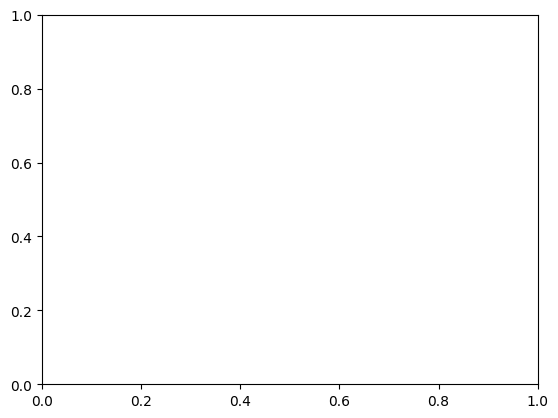

In [101]:
b = estimate_coef(X_train, y_train)
plot_regression_line(X_train, y_train, b)

In [ ]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): #A
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #B
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False
    return win